### Approximate BNN pattern analysis

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from gen_data import *
sns.set(font_scale=1)

figsize=(8,6)

#### Input pattern

In [10]:
X_train, _ = load_data('./data/', 'residual_train.pkl')
X_train2, _ = load_data('./data/', 'complex_train.pkl')

In [3]:
X_train.any() == X_train2.any()

tensor(True, device='cuda:0')

##### Fano Factor

In [27]:
def fano_factor(spike_trains):
    '''
    Computes the Fano factor of spike trains
    The fano factor is defined as the ratio of the variance to the mean of a repetition
    :param spike_trains: [n_trials, n_time_steps, n_independent_dims]
    '''
    mean = torch.mean(torch.sum(spike_trains, dim=1), dim=0)
    std = torch.std(torch.sum(spike_trains, dim=1), dim=0)
    return std ** 2 / mean
                      
fano_factor(X_train)

tensor([0.4947, 0.4984, 0.4926, 0.5017, 0.4949, 0.5035, 0.4996, 0.4851, 0.5028,
        0.5125, 0.5041, 0.5022, 0.4928, 0.4937, 0.4889, 0.5102],
       device='cuda:0')

In [48]:
# computes the entropy of a tensor
def calc_entropy(x:torch.Tensor):
    '''
    Computes the (Shannon) entropy of a tensor based on its empirical distribution
    '''
    x = x.flatten()
    freq = x.unique(return_counts=True)[1]
    probs = freq/torch.sum(freq)
    return -torch.multiply(probs, torch.log(probs)).sum()

#### Output pattern

In [5]:
_, Y_ff = load_data('./data/','feedforward_train_nonoise.pkl')
_, Y_resid = load_data('./data/','residual_train_nonoise.pkl')
_, Y_recur = load_data('./data/','recurrent_train_nonoise.pkl')
_, Y_cplx = load_data('./data/','complex_train_nonoise.pkl')
Ys = [Y_ff, Y_resid, Y_recur, Y_cplx]
d = {0: 'Feed-forward ABNN',
     1: 'Skip ABNN',
     2: 'Feed-back ABNN',
     3: 'Complex ABNN'}

In [15]:
# Y: 10000 data points, 50 time steps, 16 dimensions
d[0]

'Feed-forward ABNN'

In [12]:
# for each dimension
entropies = np.zeros(16)
for i in range(16):
    entropies[i] = calc_entropy(Y[:,:,i])
entropies

array([ 3.38247108, -0.        , 12.45175457, 13.11619568,  3.99214292,
       13.11654949, 13.1169281 ,  2.97719431, 13.11718464, 12.54573154,
       -0.        , 11.56143188, -0.        ,  3.86089659, 13.10803413,
        6.93849659])

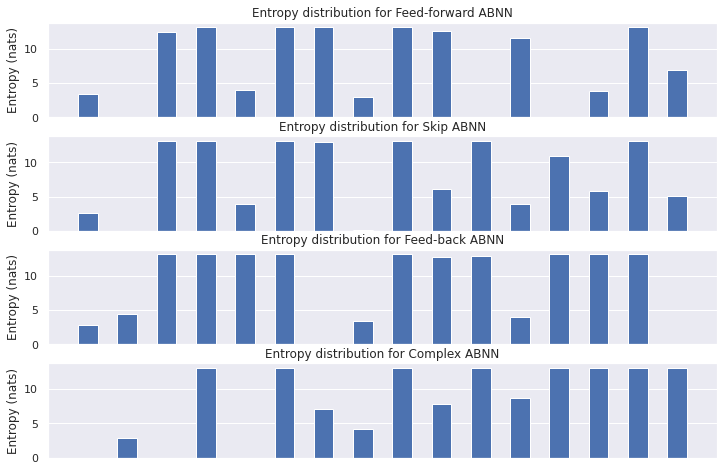

In [27]:
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(4,1,i+1)
    w = 1
    
    entropies = np.zeros(16)
    for j in range(16):
        entropies[j] = calc_entropy(Ys[i][:,:,j])
    
    plt.bar(np.arange(16) ,entropies, 0.5*w)
    plt.xticks([])
    # plt.xlabel('Output neuron')
    plt.ylabel('Entropy (nats)')
    plt.title(f'Entropy distribution for {d[i]}')
    plt.savefig('./figures/entropy_distributions.png')
plt.show()

In [ ]:
# principal component analysis of output

# standardise data
Z_scored_Y = normalise_data(Y.view(-1,16)) # normalise data
Z_scored_Y = Z_scored_Y.cpu().numpy()

cov = np.cov(Z_scored_Y.T)

# eigendecomposition and sort eigenvalues
eigenvals, eigenvecs = np.linalg.eig(cov)

idx = eigenvals.argsort()[::-1]   
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:,idx].T

pca = Z_scored_Y @ eigenvecs[:3].T

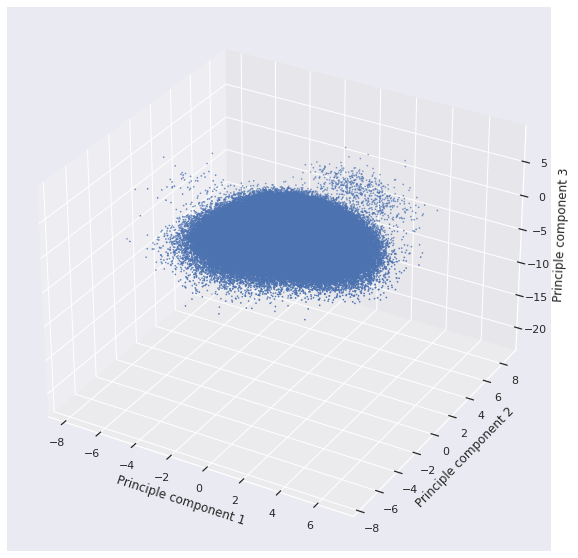

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca[:,0], pca[:,1], pca[:,2], s=0.5)
ax.set_xlabel('Principle component 1')
ax.set_ylabel('Principle component 2')
ax.set_zlabel('Principle component 3')
plt.savefig('./figures/feedforward_pca.png')
plt.show()

Text(0, 0.5, 'PC2')

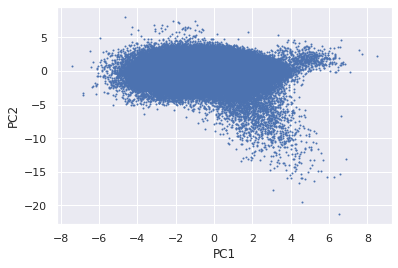

In [16]:
plt.scatter(pca[:,1], pca[:,2], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [18]:
eigenvals

array([2.34172686, 1.78043683, 1.41312196, 1.0931566 , 1.00262687,
       1.00006582, 0.99996905, 0.95418931, 0.90751246, 0.76834895,
       0.65286719, 0.4568668 , 0.35658771, 0.27252367, 0.        ,
       0.        ])

In [10]:
np.linalg.eig(cov)[1][:,0]

array([ 0.        ,  0.29979298, -0.22274757, -0.38462481, -0.04281069,
        0.05848809, -0.44857391, -0.00089331, -0.15742542, -0.49945319,
        0.        ,  0.00197991, -0.01977181, -0.06829107,  0.47440615,
       -0.04174353])

In [11]:
eigenvals

array([2.34172686, 1.78043683, 1.41312196, 1.0931566 , 1.00262687,
       1.00006582, 0.99996905, 0.95418931, 0.90751246, 0.76834895,
       0.65286719, 0.4568668 , 0.35658771, 0.27252367, 0.        ,
       0.        ])

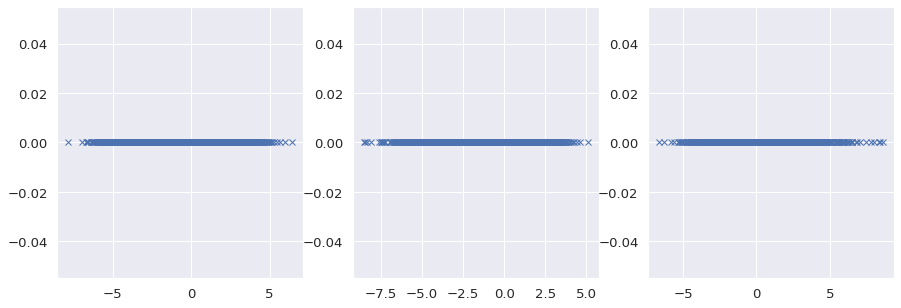

In [13]:
n = len(pca[:,0])
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(pca[:,0], np.zeros(n), 'x')
plt.subplot(132)
plt.plot(pca[:,1], np.zeros(n), 'x')
plt.subplot(133)
plt.plot(pca[:,2], np.zeros(n), 'x')